In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import math

In [3]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [4]:
data = pd.read_csv('/kaggle/input/higgs-dataset/HIGGS.csv/HIGGS.csv')
features = data.iloc[:1100000, 1:22].values 
labels = data.iloc[:1100000, 0].values
    
train_features = features[:900000]            
train_labels = labels[:900000]
    
val_features = features[900000:1000000]    
val_labels = labels[900000:1000000]
    
test_features = features[1000000:] 
test_labels = labels[1000000:]

train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
test_dataset = CustomDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# import math

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         if x.dim() == 2:  
#             x = x.unsqueeze(1)  
#         return x + self.pe[:, :x.size(1), :]
        
class ComplexTransformerAutoencoder(nn.Module):
    def __init__(self, 
                 input_dim=21,
                 d_model=512,
                 nhead=8,
                 num_encoder_layers=12,
                 dim_feedforward=1024,
                 dropout=0.2,
                 activation="gelu"):
        super(ComplexTransformerAutoencoder, self).__init__()
        
        self.input_embedding = nn.Sequential(
            nn.Linear(input_dim, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, d_model),
            nn.LayerNorm(d_model)
        )
        # self.input_embedding = nn.Linear(input_dim, d_model)
        # self.pos_encoding = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        self.decoder_head = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.BatchNorm1d(dim_feedforward),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_feedforward // 2),
            nn.BatchNorm1d(dim_feedforward // 2),
            nn.SiLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(dim_feedforward // 2, input_dim),
            nn.Sigmoid()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.BatchNorm1d(dim_feedforward),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 128), 
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x_embed = self.input_embedding(x)
        # print("Embed shape",x_embed.shape)
        # x_embed = self.pos_encoding(x_embed)
        # print("Embed shape",x_embed.shape)
        # if len(x.shape) == 2:
        #     x = x.unsqueeze(1)
        # x_embed = x_embed.squeeze(1)
        encoded = self.transformer_encoder(x_embed)
        # print("Encoded shape",encoded.shape)
        # print("Encoded squeeze shape",encoded.squeeze(1).shape)
        # print("Encoded mean shape",encoded.mean(dim=1).shape)
        
        reconstruction = self.decoder_head(encoded)  
        
        classification = self.classifier(encoded) 

        reconstruction = reconstruction.view(batch_size, -1)  
        return reconstruction, classification

In [6]:
model = ComplexTransformerAutoencoder()

In [7]:
model_path = '/kaggle/input/complexautoencoder-epoch-30/pytorch/default/1/higgs_complex_autoencoder (2).pth'
# model.load_state_dict(torch.load(model_path))


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [9]:
recon_criterion = nn.MSELoss()
class_criterion = nn.BCELoss()


train_losses = []
val_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
        
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
            
        reconstruction, classification = model(features)
            
        features = features.view(features.size(0), -1)  
        reconstruction = reconstruction.view(reconstruction.size(0), -1)  
            
        recon_loss = recon_criterion(reconstruction, features)
        class_loss = class_criterion(classification.squeeze(), labels)
        
        loss = 0.5*recon_loss + 0.5*class_loss

        optimizer.zero_grad()
        loss.backward()
            
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
        optimizer.step()
        total_loss += loss.item()
        # break
    train_losses.append(total_loss/len(train_loader))
    scheduler.step()
        
    # Validation phase
    model.eval()
    val_loss = 0
    val_preds = []
    val_true = []
        
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
                
            reconstruction, classification = model(features)
                
            features = features.view(features.size(0), -1)
            reconstruction = reconstruction.view(reconstruction.size(0), -1)
                
            val_preds.extend(classification.squeeze().cpu().numpy())
            val_true.extend(labels.cpu().numpy())
                
            recon_loss = recon_criterion(reconstruction, features)
            class_loss = class_criterion(classification.squeeze(), labels)
            val_loss += (0.5 * recon_loss + 0.5 * class_loss).item()
            # break
    val_losses.append(val_loss/len(val_loader))
    roc_auc = roc_auc_score(val_true, val_preds)
        
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {total_loss/len(train_loader):.4f}')
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    print(f'ROC-AUC Score: {roc_auc:.4f}\n')

Epoch [1/10]
Training Loss: 0.7830
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [2/10]
Training Loss: 0.7827
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [3/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [4/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [5/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [6/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [7/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [8/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [9/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000

Epoch [10/10]
Training Loss: 0.7826
Validation Loss: 0.7822
ROC-AUC Score: 0.5000



In [10]:
torch.save(model.state_dict(), "higgs_complex_autoencoder_v3.pth")

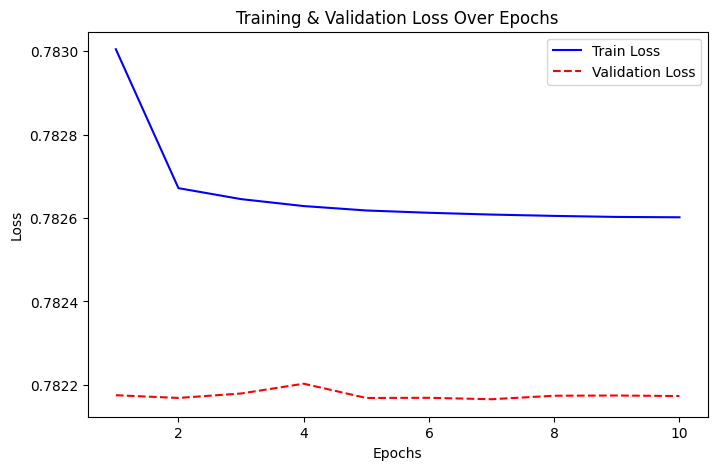

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.show()

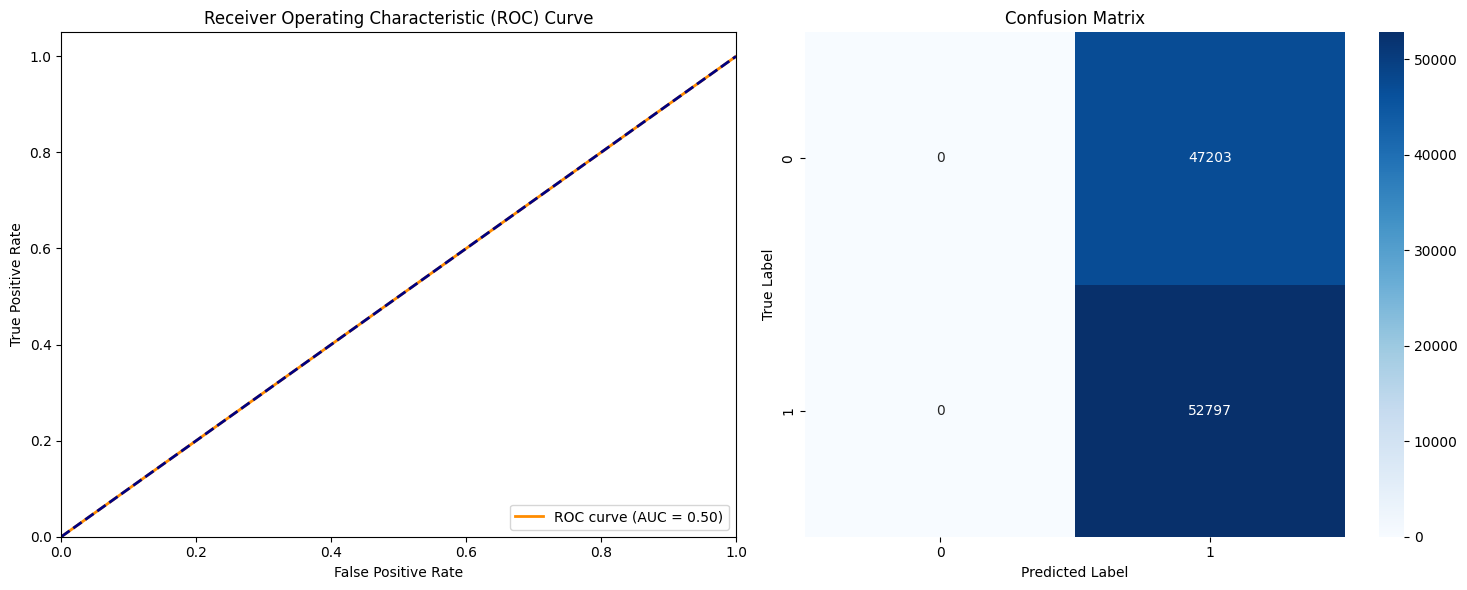

AUC Score: 0.5000
Optimal Threshold: 1.5280
Precision: 0.5280
Recall: 1.0000
F1 Score: 0.6911
Accuracy: 0.5280


In [12]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns

# Final evaluation on test set
model.eval()
test_preds = []
test_true = []
    
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        _, classification = model(features)
        test_preds.extend(classification.squeeze().cpu().numpy())
        test_true.extend(labels.numpy())

y_true = np.array(test_true)
y_scores = np.array(test_preds)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")
    
y_pred = (y_scores >= 0.5).astype(int)
    
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title('Confusion Matrix')
    
plt.tight_layout()
plt.show()
    
# Calculate additional metrics
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
    
# Compute precision, recall, F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
    
print(f"AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {np.mean(y_pred == y_true):.4f}")